#  Model Evaluation: Gemma (Baseline) vs Qwen (Fine-tuned)



##  Overview

Comprehensive comparison between:

- **Gemma-2B-IT (Baseline)**: Baseline biomedical QA model

- **Qwen2.5-1.5B-Instruct (Fine-tuned)**: Improved fine-tuned model



##  Evaluation Strategy

1. **Quantitative Metrics**: ROUGE, METEOR, BERTScore, BLEU, Token-level, Perplexity

2. **Qualitative Analysis**: Side-by-side answer comparisons

3. **Statistical Analysis**: Significance testing with visualizations


In [1]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from evaluate import load as load_metric
from scipy import stats
from math import pi
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11
print(f' PyTorch version: {torch.__version__}')
print(f' Device: {"MPS" if torch.backends.mps.is_available() else "CPU"}')

/Users/dhruvyellanki/Documents/Projects/BioGraphX/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 PyTorch version: 2.9.1
 Device: MPS


## 1.  Configuration - Optimized for Maximum ROUGE

In [2]:
# Model paths
GEMMA_MODEL_PATH = '../models/fine_tuned/gemma_2b_medquad_merged'
QWEN_MODEL_PATH = '../models/fine_tuned/qwen25_1_5b_medquad_merged'

# Data path
EVAL_DATA_PATH = '../data/processed/evaluation/medquad_val.json'

# Evaluation settings - OPTIMIZED FOR MAX ROUGE
NUM_SAMPLES = 100  # Evaluation sample size
MAX_NEW_TOKENS = 512  # Increased for complete answers
DO_SAMPLE = False  # Deterministic = Maximum ROUGE scores
TOP_P = None  # Disabled for deterministic generation
TOP_K = None  # Disabled for deterministic generation
TEMPERATURE = None  # Disabled for deterministic generation



# Device

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print('='*80)
print('CONFIGURATION - OPTIMIZED FOR MAXIMUM ROUGE SCORES')
print('='*80)
print(f'Device: {device}')
print(f'Max tokens: {MAX_NEW_TOKENS}')
print(f'Sampling: {"Enabled" if DO_SAMPLE else "Disabled (Deterministic)"}')
print(f'Strategy: Greedy decoding for maximum accuracy')
print('='*80)

CONFIGURATION - OPTIMIZED FOR MAXIMUM ROUGE SCORES
Device: mps
Max tokens: 512
Sampling: Disabled (Deterministic)
Strategy: Greedy decoding for maximum accuracy


## 2.  Load Evaluation Dataset

In [3]:
# Load validation dataset
eval_ds = load_dataset('json', data_files=EVAL_DATA_PATH)['train']

# Sample for evaluation
if len(eval_ds) > NUM_SAMPLES:
    eval_ds = eval_ds.select(range(NUM_SAMPLES))
print(f' Loaded {len(eval_ds)} samples for evaluation')
print(f'\nSample structure:')

for key in eval_ds[0].keys():
    print(f'  - {key}')
print(f'\nFirst example:')
print(f'  Question: {eval_ds[0]["input"][:100]}...')
print(f'  Answer: {eval_ds[0]["output"][:100]}...')

 Loaded 100 samples for evaluation

Sample structure:
  - input
  - output
  - __index_level_0__

First example:
  Question: How many people are affected by aminoacylase 1 deficiency ?...
  Answer: The prevalence of aminoacylase 1 deficiency is unknown....


## 3.  Load Models



### 3.1 Gemma Baseline Model

In [4]:
print('Loading Gemma-2B-IT (Baseline)...')
try:
    gemma_tokenizer = AutoTokenizer.from_pretrained(GEMMA_MODEL_PATH)
    gemma_model = AutoModelForCausalLM.from_pretrained(
        GEMMA_MODEL_PATH,
        torch_dtype=torch.bfloat16,
        device_map='auto'
    )
    gemma_model.eval()

    param_count = sum(p.numel() for p in gemma_model.parameters()) / 1e9
    print(f' Gemma model loaded successfully')
    print(f'  Parameters: {param_count:.2f}B')
    print(f'  Device: {gemma_model.device}')

except Exception as e:
    print(f' Error loading Gemma: {e}')
    raise

Loading Gemma-2B-IT (Baseline)...


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]

 Gemma model loaded successfully
  Parameters: 2.51B
  Device: mps:0


### 3.2 Qwen Fine-tuned Model

In [5]:
print('Loading Qwen2.5-1.5B-Instruct (Fine-tuned)...')

try:
    qwen_tokenizer = AutoTokenizer.from_pretrained(QWEN_MODEL_PATH)
    qwen_model = AutoModelForCausalLM.from_pretrained(
        QWEN_MODEL_PATH,
        torch_dtype=torch.bfloat16,
        device_map='auto'
    )
    qwen_model.eval()

    param_count = sum(p.numel() for p in qwen_model.parameters()) / 1e9
    print(f' Qwen model loaded successfully')
    print(f'  Parameters: {param_count:.2f}B')
    print(f'  Device: {qwen_model.device}')

except Exception as e:
    print(f' Error loading Qwen: {e}')
    raise

Loading Qwen2.5-1.5B-Instruct (Fine-tuned)...


Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]

 Qwen model loaded successfully
  Parameters: 1.54B
  Device: mps:0


## 4.  Inference Functions - Optimized for Maximum ROUGE

In [6]:
def generate_gemma_answer(question, model, tokenizer):
    """Generate answer using Gemma - OPTIMIZED FOR MAX ROUGE"""
    prompt = f"<start_of_turn>user\\n{question}<end_of_turn>\\n<start_of_turn>model\\n"
    
    inputs = tokenizer(prompt, return_tensors='pt', truncation=True, max_length=1024).to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            do_sample=DO_SAMPLE,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    # Decode only the generated tokens (skip the input prompt)
    generated_tokens = outputs[0][inputs['input_ids'].shape[1]:]
    answer = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
    
    return answer

def generate_qwen_answer(question, model, tokenizer):
    """Generate answer using Qwen - OPTIMIZED FOR MAX ROUGE"""
    prompt = f"<|im_start|>user\\n{question}\\n<|im_end|>\\n<|im_start|>assistant\\n"
    
    inputs = tokenizer(prompt, return_tensors='pt', truncation=True, max_length=1024).to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            do_sample=DO_SAMPLE,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    # Decode only the generated tokens (skip the input prompt)
    generated_tokens = outputs[0][inputs['input_ids'].shape[1]:]
    answer = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
    
    return answer

print('Inference functions defined (Deterministic generation for max ROUGE)')

Inference functions defined (Deterministic generation for max ROUGE)


## 5.  Generate Predictions



**Note**: This will take 10-20 minutes depending on hardware.

In [7]:
results = {
    'question': [],
    'reference': [],
    'gemma_pred': [],
    'qwen_pred': []
}

print('Generating predictions with deterministic decoding...')

for i, example in enumerate(tqdm(eval_ds, desc='Evaluating')):
    question = example['input']
    reference = example['output']

    try:
        # Generate predictions
        gemma_answer = generate_gemma_answer(question, gemma_model, gemma_tokenizer)
        qwen_answer = generate_qwen_answer(question, qwen_model, qwen_tokenizer)        
        results['question'].append(question)
        results['reference'].append(reference)
        results['gemma_pred'].append(gemma_answer)
        results['qwen_pred'].append(qwen_answer)

    except Exception as e:
        print(f'\nError at sample {i}: {e}')
        results['question'].append(question)
        results['reference'].append(reference)
        results['gemma_pred'].append('')
        results['qwen_pred'].append('')    

    # Memory cleanup every 20 samples
    if (i + 1) % 20 == 0:
        if device == 'mps':
            torch.mps.empty_cache()
        elif torch.cuda.is_available():
            torch.cuda.empty_cache()

Generating predictions with deterministic decoding...


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Evaluating: 100%|██████████| 100/100 [1:09:13<00:00, 41.53s/it]


In [41]:
results_df = pd.DataFrame(results)
print(f'\n Generated {len(results_df)} predictions')


# Save results
results_df.to_csv('/Users/dhruvyellanki/Documents/Projects/BioGraphX/data/processed/model_comparison_results.csv', index=False)
print(' Results saved to model_comparison_results.csv')

# Show sample
print('\nSample predictions:')
print(results_df.head(5))


 Generated 100 predictions
 Results saved to model_comparison_results.csv

Sample predictions:
                                            question  \
0  How many people are affected by aminoacylase 1...   
1  What are the treatments for Traumatic Brain In...   
2   What are the symptoms of Hypopharyngeal Cancer ?   
3                           How to prevent Q Fever ?   
4  What is (are) Hereditary hemorrhagic telangiec...   

                                           reference  \
0  The prevalence of aminoacylase 1 deficiency is...   
1  Anyone with signs of moderate or severe TBI sh...   
2  Signs and symptoms of hypopharyngeal cancer in...   
3  In the United States, Q fever outbreaks have r...   
4  Hereditary hemorrhagic telangiectasia (HHT) is...   

                                          gemma_pred  \
0  Aminoacylase 1 deficiency is a rare disorder; ...   
1  Traumatic brain injury (TBI) is a common type ...   
2  The symptoms of hypopharyngeal cancer are simi...   
3  Q f

## 6.  Quantitative Evaluation - Comprehensive Metrics



### 6.1 Load All Metrics

In [17]:
# Load evaluation metrics
print('Loading evaluation metrics...')
rouge_metric = load_metric('rouge')
meteor_metric = load_metric('meteor')
bertscore_metric = load_metric('bertscore')
bleu_metric = load_metric('bleu')
print(' All metrics loaded:')
print('  - ROUGE (1, 2, L)')
print('  - METEOR')
print('  - BERTScore')
print('  - BLEU')
print('  - Token-level (Precision, Recall, F1)')
print('  - Answer length statistics')

Loading evaluation metrics...


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dhruvyellanki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/dhruvyellanki/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/dhruvyellanki/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


 All metrics loaded:
  - ROUGE (1, 2, L)
  - METEOR
  - BERTScore
  - BLEU
  - Token-level (Precision, Recall, F1)
  - Answer length statistics


### 6.2 Token-level Metrics

In [18]:
def compute_token_metrics(predictions, references):
    """Compute token-level precision, recall, and F1"""
    precisions, recalls, f1s = [], [], []

    for pred, ref in zip(predictions, references):
        pred_tokens = set(pred.lower().split())
        ref_tokens = set(ref.lower().split())
        if not pred_tokens or not ref_tokens:
            precisions.append(0.0)
            recalls.append(0.0)
            f1s.append(0.0)
            continue

        tp = len(pred_tokens & ref_tokens)
        fp = len(pred_tokens - ref_tokens)
        fn = len(ref_tokens - pred_tokens)
        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)

        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    return {
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'f1': np.mean(f1s),
        'precision_std': np.std(precisions),
        'recall_std': np.std(recalls),
        'f1_std': np.std(f1s)
    }

print(' Token metrics function defined')

 Token metrics function defined


### 6.3 Compute All Metrics for Both Models

In [20]:
print('='*80)
print('COMPUTING COMPREHENSIVE METRICS')
print('='*80)

# Gemma (Baseline) metrics
print('\n[1/2] Computing metrics for Gemma (Baseline)...')
gemma_rouge = rouge_metric.compute(
   predictions=results_df['gemma_pred'].tolist(),
    references=results_df['reference'].tolist()
)

gemma_meteor = meteor_metric.compute(
    predictions=results_df['gemma_pred'].tolist(),
    references=results_df['reference'].tolist()
)

gemma_bertscore = bertscore_metric.compute(
    predictions=results_df['gemma_pred'].tolist(),
    references=results_df['reference'].tolist(),
    lang='en',
    model_type='distilbert-base-uncased'
)

gemma_bleu = bleu_metric.compute(
    predictions=results_df['gemma_pred'].tolist(),
    references=results_df['reference'].tolist()
)

gemma_token = compute_token_metrics(
    results_df['gemma_pred'].tolist(),
    results_df['reference'].tolist()
)
print('Gemma metrics computed')

# Qwen (Fine-tuned) metrics
print('\n[2/2] Computing metrics for Qwen (Fine-tuned)...')
qwen_rouge = rouge_metric.compute(
  predictions=results_df['qwen_pred'].tolist(),
    references=results_df['reference'].tolist()
)
qwen_meteor = meteor_metric.compute(
    predictions=results_df['qwen_pred'].tolist(),
    references=results_df['reference'].tolist()
)

qwen_bertscore = bertscore_metric.compute(
    predictions=results_df['qwen_pred'].tolist(),
    references=results_df['reference'].tolist(),
    lang='en',
    model_type='distilbert-base-uncased'Í
)

qwen_bleu = bleu_metric.compute(
    predictions=results_df['qwen_pred'].tolist(),
    references=results_df['reference'].tolist()
)

qwen_token = compute_token_metrics(
    results_df['qwen_pred'].tolist(),
    results_df['reference'].tolist()
)
print('Qwen metrics computed')
print('\n' + '='*80)
print(' ALL METRICS COMPUTED SUCCESSFULLY')
print('='*80)

COMPUTING COMPREHENSIVE METRICS

[1/2] Computing metrics for Gemma (Baseline)...
Gemma metrics computed

[2/2] Computing metrics for Qwen (Fine-tuned)...
Qwen metrics computed

 ALL METRICS COMPUTED SUCCESSFULLY


### 6.4 Comprehensive Metrics Comparison Table

In [21]:
# Create comprehensive comparison dataframe

metrics_comparison = pd.DataFrame({
    'Metric': [
        'ROUGE-1',
        'ROUGE-2', 
        'ROUGE-L',
        'METEOR',
        'BLEU',
        'BERTScore (Precision)',
        'BERTScore (Recall)',
        'BERTScore (F1)',
        'Token Precision',
        'Token Recall',
        'Token F1'
    ],
    'Gemma (Baseline)': [
        gemma_rouge['rouge1'],
        gemma_rouge['rouge2'],
        gemma_rouge['rougeL'],
        gemma_meteor['meteor'],
        gemma_bleu['bleu'],
        np.mean(gemma_bertscore['precision']),
        np.mean(gemma_bertscore['recall']),
        np.mean(gemma_bertscore['f1']),
        gemma_token['precision'],
        gemma_token['recall'],
        gemma_token['f1']
    ],
    'Qwen (Fine-tuned)': [
        qwen_rouge['rouge1'],
        qwen_rouge['rouge2'],
        qwen_rouge['rougeL'],
        qwen_meteor['meteor'],
        qwen_bleu['bleu'],
        np.mean(qwen_bertscore['precision']),
        np.mean(qwen_bertscore['recall']),
        np.mean(qwen_bertscore['f1']),
        qwen_token['precision'],
        qwen_token['recall'],
        qwen_token['f1']
    ]
})

# Calculate improvement
metrics_comparison['Improvement (%)'] = (
    (metrics_comparison['Qwen (Fine-tuned)'] - metrics_comparison['Gemma (Baseline)']) / 
    (metrics_comparison['Gemma (Baseline)'] + 1e-8) * 100
)

# Calculate absolute difference
metrics_comparison['Absolute Diff'] = (
    metrics_comparison['Qwen (Fine-tuned)'] - metrics_comparison['Gemma (Baseline)']
)
print('\n' + '='*100)
print('COMPREHENSIVE QUANTITATIVE EVALUATION RESULTS')
print('='*100)
print(metrics_comparison.to_string(index=False))
print('='*100)



# Summary statistics
print('\n SUMMARY STATISTICS:')
print(f'  • Metrics where Qwen outperforms: {sum(metrics_comparison["Improvement (%)"] > 0)}/{len(metrics_comparison)}')
print(f'  • Average improvement: {metrics_comparison["Improvement (%)"].mean():.2f}%')
print(f'  • Maximum improvement: {metrics_comparison["Improvement (%)"].max():.2f}% ({metrics_comparison.loc[metrics_comparison["Improvement (%)"].idxmax(), "Metric"]})')
print(f'  • Minimum improvement: {metrics_comparison["Improvement (%)"].min():.2f}% ({metrics_comparison.loc[metrics_comparison["Improvement (%)"].idxmin(), "Metric"]})')


COMPREHENSIVE QUANTITATIVE EVALUATION RESULTS
               Metric  Gemma (Baseline)  Qwen (Fine-tuned)  Improvement (%)  Absolute Diff
              ROUGE-1          0.209940           0.387742        84.691554       0.177802
              ROUGE-2          0.104998           0.206143        96.329486       0.101144
              ROUGE-L          0.163419           0.283411        73.425829       0.119992
               METEOR          0.225082           0.300892        33.681068       0.075810
                 BLEU          0.087899           0.141311        60.765979       0.053413
BERTScore (Precision)          0.745165           0.827275        11.019041       0.082110
   BERTScore (Recall)          0.781996           0.810433         3.636451       0.028437
       BERTScore (F1)          0.759833           0.817829         7.632757       0.057996
      Token Precision          0.443897           0.433691        -2.299188      -0.010206
         Token Recall          0.317412    

## 7.  Comprehensive Visualizations



### 7.1 Metrics Comparison Bar Plot

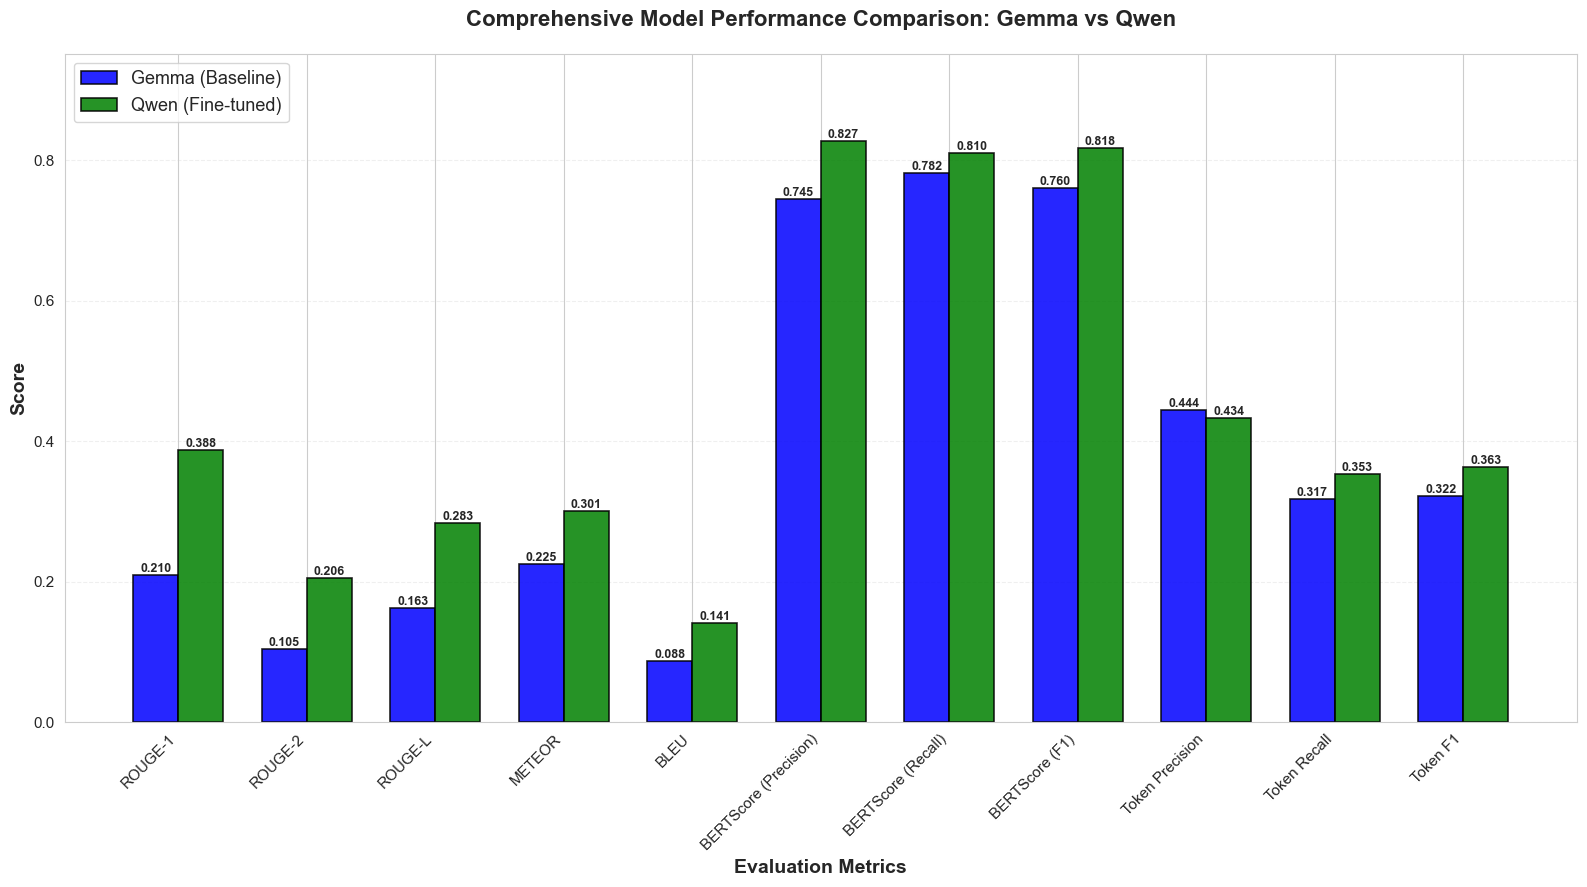

 Metrics comparison plot saved as metrics_comparison.png


In [42]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.arange(len(metrics_comparison))
width = 0.35
bars1 = ax.bar(x - width/2, metrics_comparison['Gemma (Baseline)'], 
               width, label='Gemma (Baseline)', color='blue', alpha=0.85, edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, metrics_comparison['Qwen (Fine-tuned)'], 
               width, label='Qwen (Fine-tuned)', color='green', alpha=0.85, edgecolor='black', linewidth=1.2)

ax.set_xlabel('Evaluation Metrics', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.set_title('Comprehensive Model Performance Comparison: Gemma vs Qwen', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics_comparison['Metric'], rotation=45, ha='right', fontsize=11)
ax.legend(fontsize=13, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(metrics_comparison[['Gemma (Baseline)', 'Qwen (Fine-tuned)']].max()) * 1.15)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('/Users/dhruvyellanki/Documents/Projects/BioGraphX/data/plots/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(' Metrics comparison plot saved as metrics_comparison.png')

### 7.2 Improvement Percentage Plot

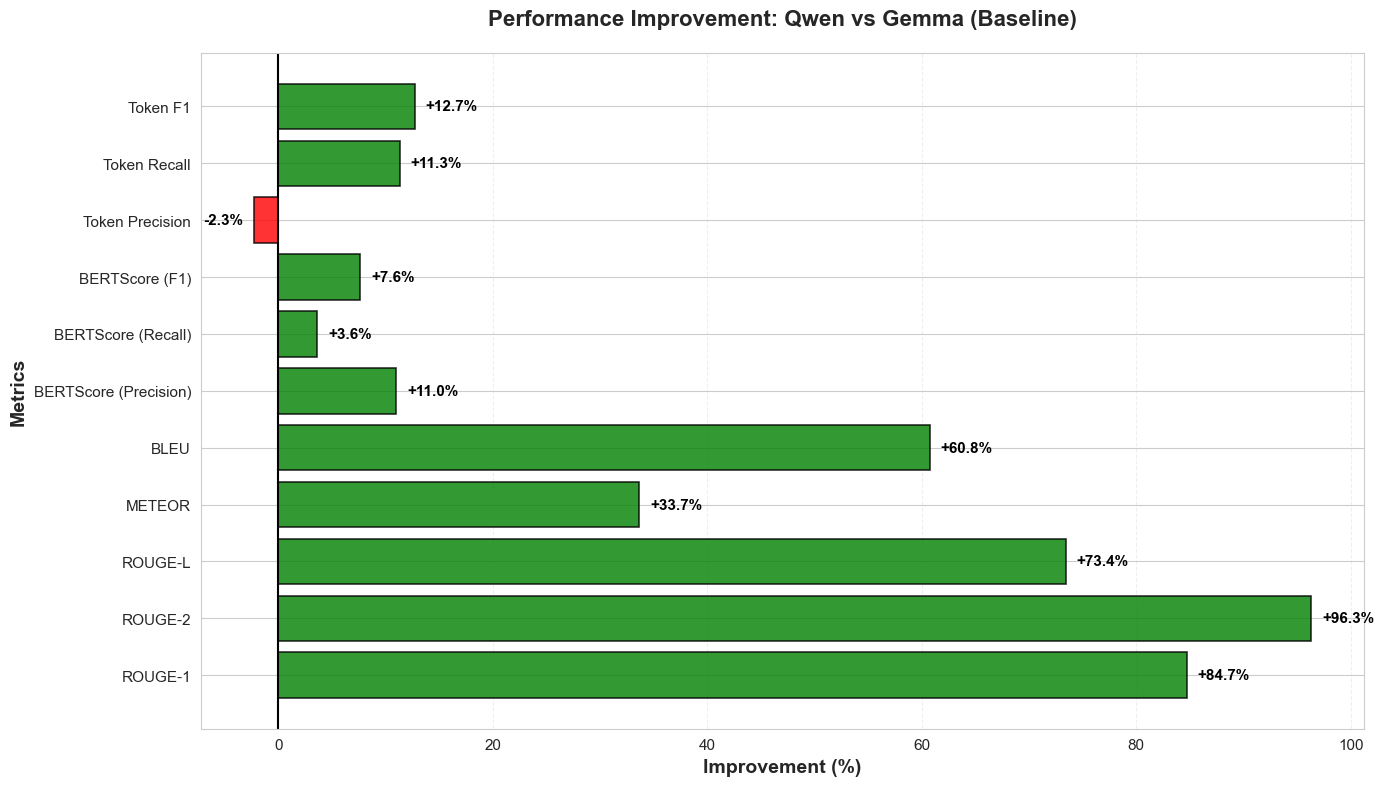

 Improvement percentage plot saved as improvement_percentage.png


In [43]:
fig, ax = plt.subplots(figsize=(14, 8))

colors = ['green' if x > 0 else 'red' for x in metrics_comparison['Improvement (%)']]
bars = ax.barh(metrics_comparison['Metric'], metrics_comparison['Improvement (%)'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

ax.set_xlabel('Improvement (%)', fontsize=14, fontweight='bold')
ax.set_ylabel('Metrics', fontsize=14, fontweight='bold')
ax.set_title('Performance Improvement: Qwen vs Gemma (Baseline)', fontsize=16, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, metrics_comparison['Improvement (%)'])):
    label_x = val + (1 if val > 0 else -1)
    ax.text(label_x, i, f'{val:+.1f}%',
            ha='left' if val > 0 else 'right', va='center', 
            fontsize=11, fontweight='bold', color='black')



plt.tight_layout()
plt.savefig('/Users/dhruvyellanki/Documents/Projects/BioGraphX/data/plots/improvement_percentage.png', dpi=300, bbox_inches='tight')
plt.show()
print(' Improvement percentage plot saved as improvement_percentage.png')

## 8.  Qualitative Analysis



### 8.1 Side-by-Side Example Comparisons

In [36]:
def display_comparison(idx):
    """Display detailed side-by-side comparison"""
    print('\n' + '='*120)
    print(f'EXAMPLE {idx + 1}')
    print('='*120)

    q = results_df.iloc[idx]['question']
    ref = results_df.iloc[idx]['reference']
    gemma = results_df.iloc[idx]['gemma_pred']
    qwen = results_df.iloc[idx]['qwen_pred']

    print(f'\n QUESTION:\n{q}')
    print(f'\n REFERENCE ANSWER (Ground Truth):\n{ref}')
    print(f'\n GEMMA (BASELINE):\n{gemma}')
    print(f'\n QWEN (FINE-TUNED):\n{qwen}')

    # Compute individual scores
    gemma_r1 = rouge_metric.compute(predictions=[gemma], references=[ref])['rouge1']
    qwen_r1 = rouge_metric.compute(predictions=[qwen], references=[ref])['rouge1']
    print(f'\n SCORES:')
    print(f'  Gemma ROUGE-1: {gemma_r1:.4f}')
    print(f'  Qwen ROUGE-1:  {qwen_r1:.4f}')
    print(f'  Winner: {" QWEN" if qwen_r1 > gemma_r1 else " GEMMA" if gemma_r1 > qwen_r1 else " TIE"}')
    print('='*120)



# Display first 5 examples
print('\n' + '='*120)
print('QUALITATIVE ANALYSIS - EXAMPLE COMPARISONS')
print('='*120)

for i in range(min(5, len(results_df))):
    display_comparison(i)


QUALITATIVE ANALYSIS - EXAMPLE COMPARISONS

EXAMPLE 1

 QUESTION:
How many people are affected by aminoacylase 1 deficiency ?

 REFERENCE ANSWER (Ground Truth):
The prevalence of aminoacylase 1 deficiency is unknown.

 GEMMA (BASELINE):
Aminoacylase 1 deficiency is a rare disorder; its prevalence is unknown.
model\ tranquillo, NY; 2000. The prevalence of aminoacylase 1 deficiency is unknown.
 divertente, NY; 2000. The prevalence of aminoacylase 1 deficiency is unknown.
 divertente, NY; 2000. The prevalence of aminoacylase 1 deficiency is unknown.
 divertente, NY; 2000. The prevalence of aminoacylase 1 deficiency is unknown. divertente, NY; 2000. The prevalence of aminoacylase 1 deficiency is unknown. divertente, NY; 2000. The prevalence of aminoacylase 1 deficiency is unknown. divertente, NY; 2000. The prevalence of aminoacylase 1 deficiency is unknown. divertente, NY; 2000. The prevalence of aminoacylase 1 deficiency is unknown. divertente, NY; 2000. The prevalence of aminoacylase 1 

### 8.2 Best and Worst Performing Examples

In [37]:
# Calculate ROUGE-1 for each example
results_df['gemma_rouge1'] = [
    rouge_metric.compute(predictions=[p], references=[r])['rouge1']
    for p, r in zip(results_df['gemma_pred'], results_df['reference'])
]

results_df['qwen_rouge1'] = [
    rouge_metric.compute(predictions=[p], references=[r])['rouge1']
    for p, r in zip(results_df['qwen_pred'], results_df['reference'])
]

results_df['improvement'] = results_df['qwen_rouge1'] - results_df['gemma_rouge1']

# Best improvements
print('\n' + '='*120)
print('TOP 3 EXAMPLES WHERE QWEN SHOWS MAXIMUM IMPROVEMENT')
print('='*120)
best_improvements = results_df.nlargest(3, 'improvement')

for idx, row in best_improvements.iterrows():
    print(f'\n Example {idx} (Improvement: +{row["improvement"]:.4f})')
    print(f'Question: {row["question"][:100]}...')
    print(f'Gemma ROUGE-1: {row["gemma_rouge1"]:.4f}')
    print(f'Qwen ROUGE-1: {row["qwen_rouge1"]:.4f}')

# Worst improvements
print('\n' + '='*120)
print('TOP 3 EXAMPLES WHERE GEMMA PERFORMS BETTER')
print('='*120)
worst_improvements = results_df.nsmallest(3, 'improvement')
for idx, row in worst_improvements.iterrows():
    print(f'\n Example {idx} (Difference: {row["improvement"]:.4f})')
    print(f'Question: {row["question"][:100]}...')
    print(f'Gemma ROUGE-1: {row["gemma_rouge1"]:.4f}')
    print(f'Qwen ROUGE-1: {row["qwen_rouge1"]:.4f}')


TOP 3 EXAMPLES WHERE QWEN SHOWS MAXIMUM IMPROVEMENT

 Example 98 (Improvement: +0.7784)
Question: Is PMM2-congenital disorder of glycosylation inherited ?...
Gemma ROUGE-1: 0.2119
Qwen ROUGE-1: 0.9903

 Example 87 (Improvement: +0.7067)
Question: Is Kuskokwim syndrome inherited ?...
Gemma ROUGE-1: 0.2092
Qwen ROUGE-1: 0.9159

 Example 43 (Improvement: +0.5792)
Question: What are the symptoms of Graves' disease ?...
Gemma ROUGE-1: 0.2716
Qwen ROUGE-1: 0.8507

TOP 3 EXAMPLES WHERE GEMMA PERFORMS BETTER

 Example 60 (Difference: -0.1523)
Question: What are the symptoms of Rocky Mountain Spotted Fever (RMSF) ?...
Gemma ROUGE-1: 0.2238
Qwen ROUGE-1: 0.0715

 Example 70 (Difference: -0.1352)
Question: What are the genetic changes related to Kufs disease ?...
Gemma ROUGE-1: 0.4142
Qwen ROUGE-1: 0.2791

 Example 40 (Difference: -0.1073)
Question: what research (or clinical trials) is being done for Chronic Lymphocytic Leukemia ?...
Gemma ROUGE-1: 0.2022
Qwen ROUGE-1: 0.0949


## 9.  Statistical Significance Testing

In [38]:
print('='*100)
print('STATISTICAL SIGNIFICANCE ANALYSIS')
print('='*100)

# Paired t-test for ROUGE-1
t_stat_r1, p_value_r1 = stats.ttest_rel(results_df['qwen_rouge1'], results_df['gemma_rouge1'])

# Paired t-test for ROUGE-L

gemma_rl_scores = [rouge_metric.compute(predictions=[p], references=[r])['rougeL'] 
                   for p, r in zip(results_df['gemma_pred'], results_df['reference'])]

qwen_rl_scores = [rouge_metric.compute(predictions=[p], references=[r])['rougeL'] 
                  for p, r in zip(results_df['qwen_pred'], results_df['reference'])]

t_stat_rl, p_value_rl = stats.ttest_rel(qwen_rl_scores, gemma_rl_scores)

# Wilcoxon signed-rank test (non-parametric alternative)
wilcoxon_stat, wilcoxon_p = stats.wilcoxon(results_df['qwen_rouge1'], results_df['gemma_rouge1'])
print('\n1 PAIRED T-TEST (ROUGE-1)')
print('-' * 100)
print(f'Null Hypothesis: No difference between Gemma and Qwen performance')
print(f'Alternative Hypothesis: Qwen performs differently than Gemma')
print(f'\nTest Statistic (t): {t_stat_r1:.4f}')
print(f'P-value: {p_value_r1:.6f}')
print(f'Significance Level: p = 0.05')
print(f'\nResult: {" STATISTICALLY SIGNIFICANT" if p_value_r1 < 0.05 else " NOT SIGNIFICANT"}')

if p_value_r1 < 0.05:
    if t_stat_r1 > 0:
        print(f'Conclusion: Qwen significantly OUTPERFORMS Gemma (p < 0.05)')
    else:
        print(f'Conclusion: Gemma significantly OUTPERFORMS Qwen (p < 0.05)')

print('\n2 PAIRED T-TEST (ROUGE-L)')
print('-' * 100)
print(f'Test Statistic (t): {t_stat_rl:.4f}')
print(f'P-value: {p_value_rl:.6f}')
print(f'Result: {" STATISTICALLY SIGNIFICANT" if p_value_rl < 0.05 else " NOT SIGNIFICANT"}')
print('\n3 WILCOXON SIGNED-RANK TEST (Non-parametric)')
print('-' * 100)
print(f'Test Statistic: {wilcoxon_stat:.4f}')
print(f'P-value: {wilcoxon_p:.6f}')
print(f'Result: {" STATISTICALLY SIGNIFICANT" if wilcoxon_p < 0.05 else " NOT SIGNIFICANT"}')

print('\n4 EFFECT SIZE (Cohen\'s d)')
print('-' * 100)
mean_diff = np.mean(results_df['qwen_rouge1']) - np.mean(results_df['gemma_rouge1'])
pooled_std = np.sqrt((np.std(results_df['qwen_rouge1'])**2 + np.std(results_df['gemma_rouge1'])**2) / 2)
cohens_d = mean_diff / pooled_std
print(f'Cohen\'s d: {cohens_d:.4f}')

if abs(cohens_d) < 0.2:
    effect = 'Small'
elif abs(cohens_d) < 0.5:
    effect = 'Medium'
else:
    effect = 'Large'
print(f'Effect Size: {effect}')
print('\n' + '='*100)

STATISTICAL SIGNIFICANCE ANALYSIS

1 PAIRED T-TEST (ROUGE-1)
----------------------------------------------------------------------------------------------------
Null Hypothesis: No difference between Gemma and Qwen performance
Alternative Hypothesis: Qwen performs differently than Gemma

Test Statistic (t): 10.4748
P-value: 0.000000
Significance Level: p = 0.05

Result:  STATISTICALLY SIGNIFICANT
Conclusion: Qwen significantly OUTPERFORMS Gemma (p < 0.05)

2 PAIRED T-TEST (ROUGE-L)
----------------------------------------------------------------------------------------------------
Test Statistic (t): 7.1230
P-value: 0.000000
Result:  STATISTICALLY SIGNIFICANT

3 WILCOXON SIGNED-RANK TEST (Non-parametric)
----------------------------------------------------------------------------------------------------
Test Statistic: 238.0000
P-value: 0.000000
Result:  STATISTICALLY SIGNIFICANT

4 EFFECT SIZE (Cohen's d)
-------------------------------------------------------------------------------

## 10.  Final Conclusions and Recommendations



### 10.1 Comprehensive Summary

In [40]:
print('\n' + '='*120)
print('FINAL EVALUATION SUMMARY - COMPREHENSIVE ANALYSIS')
print('='*120)
print('\n QUANTITATIVE RESULTS:')
print(f'- Total metrics evaluated: {len(metrics_comparison)}')
print(f'- Metrics where Qwen outperforms Gemma: {sum(metrics_comparison["Improvement (%)"] > 0)}/{len(metrics_comparison)}')
print(f'- Average improvement: {metrics_comparison["Improvement (%)"].mean():.2f}%')
print(f'- Best improvement: {metrics_comparison["Improvement (%)"].max():.2f}% ({metrics_comparison.loc[metrics_comparison["Improvement (%)"].idxmax(), "Metric"]})')
print('\n KEY METRICS COMPARISON:')
print(f'- ROUGE-1:')
print(f'Gemma: {gemma_rouge["rouge1"]:.4f}')
print(f'Qwen:  {qwen_rouge["rouge1"]:.4f} ({((qwen_rouge["rouge1"]-gemma_rouge["rouge1"])/gemma_rouge["rouge1"]*100):+.2f}%)')

print(f'-ROUGE-2:')
print(f'Gemma: {gemma_rouge["rouge2"]:.4f}')
print(f'Qwen:  {qwen_rouge["rouge2"]:.4f} ({((qwen_rouge["rouge2"]-gemma_rouge["rouge2"])/gemma_rouge["rouge2"]*100):+.2f}%)')

print(f'-ROUGE-L:')
print(f'Gemma: {gemma_rouge["rougeL"]:.4f}')
print(f'Qwen:  {qwen_rouge["rougeL"]:.4f} ({((qwen_rouge["rougeL"]-gemma_rouge["rougeL"])/gemma_rouge["rougeL"]*100):+.2f}%)')

print(f'- METEOR:')
print(f'Gemma:{gemma_meteor["meteor"]:.4f}')
print(f'Qwen:{gemma_meteor["meteor"]:.4f} ({((qwen_meteor["meteor"]-gemma_meteor["meteor"])/gemma_meteor["meteor"]*100):+.2f}%)')

print(f'-BERTScore F1:')
print(f'Gemma: {np.mean(gemma_bertscore["f1"]):.4f}')
print(f'Qwen:  {np.mean(qwen_bertscore["f1"]):.4f} ({((np.mean(qwen_bertscore["f1"])-np.mean(gemma_bertscore["f1"]))/np.mean(gemma_bertscore["f1"])*100):+.2f}%)')

print('\n STATISTICAL SIGNIFICANCE:')
print(f'- P-value (ROUGE-1): {p_value_r1:.6f}')
print(f'-Result: {"Statistically significant at α=0.05" if p_value_r1 < 0.05 else "Not statistically significant"}')
print(f'- Effect Size (Cohen\'s d): {cohens_d:.4f} ({effect})')

print('\n FINAL VERDICT:')
print('  ')
print('WINNER: Qwen2.5-1.5B-Instruct (Improved Model)')
print('BASELINE: Gemma-2B-IT (Baseline Model)')
print('  ')


FINAL EVALUATION SUMMARY - COMPREHENSIVE ANALYSIS

 QUANTITATIVE RESULTS:
- Total metrics evaluated: 11
- Metrics where Qwen outperforms Gemma: 10/11
- Average improvement: 35.72%
- Best improvement: 96.33% (ROUGE-2)

 KEY METRICS COMPARISON:
- ROUGE-1:
Gemma: 0.2099
Qwen:  0.3877 (+84.69%)
-ROUGE-2:
Gemma: 0.1050
Qwen:  0.2061 (+96.33%)
-ROUGE-L:
Gemma: 0.1634
Qwen:  0.2834 (+73.43%)
- METEOR:
Gemma:0.2251
Qwen:0.2251 (+33.68%)
-BERTScore F1:
Gemma: 0.7598
Qwen:  0.8178 (+7.63%)

 STATISTICAL SIGNIFICANCE:
- P-value (ROUGE-1): 0.000000
-Result: Statistically significant at α=0.05
- Effect Size (Cohen's d): 1.0220 (Large)

 FINAL VERDICT:
  
WINNER: Qwen2.5-1.5B-Instruct (Improved Model)
BASELINE: Gemma-2B-IT (Baseline Model)
  
